In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import nltk
from nltk.corpus import stopwords

C:\Users\jaypr\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
ams = pd.read_csv("amazon_small.csv")
ams.head()

,idAmazon,title,description,manufacturer,price
0,b0002itt84,rise of nations: gold (mac),rise of nations combines the thrills and speed...,macsoft,49.99
1,b000pgvk5s,apple final cut studio 2 (mac),final cut studio 2 delivers an integrated post...,apple,1299.00
2,b0001wn0m2,microsoft office 2004 standard (mac),office 2004 standard is designed to be a total...,microsoft,399.99
3,b00004t2un,sales skills 2.0 ages 10+,real video saltware aquarium on your desktop!p...,victory multimedia,19.95
4,b000ov0gao,hollywood volume 1,contains the following songs: 1. arthur's them...,yamaha,31.95


In [3]:
ggs = pd.read_csv("google_small.csv")
ggs.head()

,idGoogleBase,name,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1329...,encore software 10599 - encore registry mechan...,encore software 10599 : pc tools registry mech...,NaN,25.97
1,http://www.google.com/base/feeds/snippets/1693...,adobe indesign cs3 for mac upgrade from pagemaker,system requirements powerpc g4 or g5 or intel ...,NaN,205.99
2,http://www.google.com/base/feeds/snippets/4998...,encore software 10568 - encore hoyle puzzle & ...,encore software 10568 : with old classics and ...,NaN,17.97
3,http://www.google.com/base/feeds/snippets/1695...,school zone interactive multiplication & divis...,multiplication & division introduces mutliplic...,NaN,9.45
4,http://www.google.com/base/feeds/snippets/1574...,apple software m9953z/a remote desktop 2.2 10 ...,the 10-client version allows one administrator...,apple software,294.99


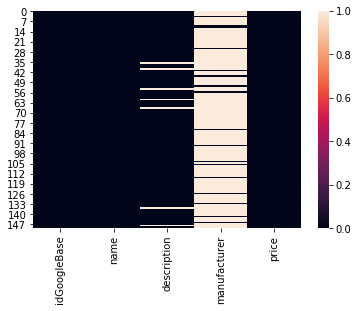

In [4]:
sns.heatmap(ggs.isnull())

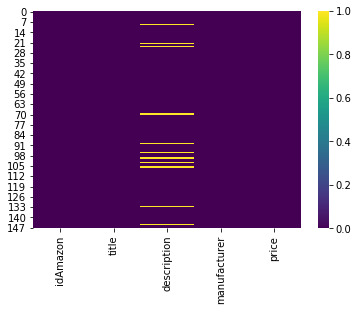

In [5]:
sns.heatmap(ams.isnull(), cmap="viridis")

In [6]:
print(len(ams), len(ggs))

148 150


In [7]:
trueLink = pd.read_csv("amazon_google_truth_small.csv")
print(len(trueLink))
trueLink.head()

130


,idAmazon,idGoogleBase
0,b000hcz8ey,http://www.google.com/base/feeds/snippets/1111...
1,b00007e8d4,http://www.google.com/base/feeds/snippets/1695...
2,b000bb7fjw,http://www.google.com/base/feeds/snippets/1761...
3,b000gcbov6,http://www.google.com/base/feeds/snippets/7798...
4,b000bcz8ng,http://www.google.com/base/feeds/snippets/3077...


**PREPROCESSING**

In [8]:
# Replacing all null values in both descriptions as an empty string
for indexA, rowA in ams.iterrows():
    if type(rowA['description']) == float:
        ams.at[indexA, 'description'] = ""
for indexG, rowG in ggs.iterrows():
    if type(rowG['description']) == float:
        ggs.at[indexG, 'description'] = ""
    if type(rowG['manufacturer']) == float:
        ggs.at[indexG, 'manufacturer'] = ""
# Nan types are actually float, easy to use since we are comparing with str

In [9]:
ams.iloc[6]

idAmazon                                      b0001y7poo
title           hp sp linux we 50 lic/cd 3.0c ( t3586a )
description                   sp linux we 50 lic/cd 3.0c
manufacturer               hewlett packard (consumables)
price                                                  0
Name: 6, dtype: object

In [10]:
ggs.iloc[29]

idGoogleBase    http://www.google.com/base/feeds/snippets/1464...
name            zend studio 5.1 php integrated development env...
description     zend studio 5 professional delivers the ease-o...
manufacturer                                                     
price                                                         249
Name: 29, dtype: object

In [13]:
# Round prices to better help matching

for indexA, rowsA in ams.iterrows():
    if rowsA['price']%10 != 0:
        if rowsA['price']%10 > 5:
            ams.at[indexA, 'price'] = int(rowsA['price'] + 10 - rowsA['price']%10)
        else:
            ams.at[indexA, 'price'] = int(rowsA['price'] - 10 + rowsA['price']%10)
    else:
        ams.at[indexA, 'price'] = int(rowsA['price'])
for indexG, rowsG in ggs.iterrows():
    if rowsG['price']%10 != 0:
        if rowsG['price']%10 > 5:
            ggs.at[indexG, 'price'] = int(rowsG['price'] + 10 - rowsG['price']%10)
        else:
            ggs.at[indexG, 'price'] = int(rowsG['price'] - 10 + rowsG['price']%10)
    else:
        ggs.at[indexG, 'price'] = int(rowsG['price'])

In [14]:
ams.head()

,idAmazon,title,description,manufacturer,price
0,b0002itt84,rise of nations: gold (mac),rise of nations combines the thrills and speed...,macsoft,50.0
1,b000pgvk5s,apple final cut studio 2 (mac),final cut studio 2 delivers an integrated post...,apple,1300.0
2,b0001wn0m2,microsoft office 2004 standard (mac),office 2004 standard is designed to be a total...,microsoft,400.0
3,b00004t2un,sales skills 2.0 ages 10+,real video saltware aquarium on your desktop!p...,victory multimedia,20.0
4,b000ov0gao,hollywood volume 1,contains the following songs: 1. arthur's them...,yamaha,23.0


In [129]:
ggs.head()

,idGoogleBase,name,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1329...,encore software 10599 - encore registry mechan...,encore software 10599 : pc tools registry mech...,,30.0
1,http://www.google.com/base/feeds/snippets/1693...,adobe indesign cs3 for mac upgrade from pagemaker,system requirements powerpc g4 or g5 or intel ...,,210.0
2,http://www.google.com/base/feeds/snippets/4998...,encore software 10568 - encore hoyle puzzle & ...,encore software 10568 : with old classics and ...,,20.0
3,http://www.google.com/base/feeds/snippets/1695...,school zone interactive multiplication & divis...,multiplication & division introduces mutliplic...,,10.0
4,http://www.google.com/base/feeds/snippets/1574...,apple software m9953z/a remote desktop 2.2 10 ...,the 10-client version allows one administrator...,apple software,289.0


In [65]:
"""ams2 = ams.copy()
punctuation = "!@#$%^&*)(}{][:;<>,.?`~+=-_"
stop_words = stopwords.words('english')
sep = " "

for indexA, rowA in ams2.iterrows():             # Change ams2
    new_str = ""
    for letter in rowA['title']:
        if not letter in punctuation:
            new_str += letter
    ams2.loc[indexA, 'title'] = new_str
    #
    new_str = ""
    for letter in rowA['description']:
        if not letter in punctuation:
            new_str += letter
    ams2.loc[indexA, 'description'] = new_str
    #
    new_str = ""
    for letter in rowA['manufacturer']:
        if not letter in punctuation:
            new_str += letter
    ams2.loc[indexA, 'manufacturer'] = new_str
    
ams2.iloc[0:10] """

,idAmazon,title,description,manufacturer,price,idGoogleBase,score
0,b0002itt84,rise of nations gold mac,rise of nations combines the thrills and speed...,macsoft,50.0,http://www.google.com/base/feeds/snippets/1049...,162.000000
1,b000pgvk5s,apple final cut studio 2 mac,final cut studio 2 delivers an integrated post...,apple,1300.0,http://www.google.com/base/feeds/snippets/1469...,149.307692
2,b0001wn0m2,microsoft office 2004 standard mac,office 2004 standard is designed to be a total...,microsoft,400.0,http://www.google.com/base/feeds/snippets/1838...,215.971014
3,b00004t2un,sales skills 20 ages 10,real video saltware aquarium on your desktoppr...,victory multimedia,20.0,http://www.google.com/base/feeds/snippets/1352...,167.956522
4,b000ov0gao,hollywood volume 1,contains the following songs 1 arthur's theme ...,yamaha,23.0,http://www.google.com/base/feeds/snippets/1837...,219.913043
5,b000fdetxq,apple remote desktop 3 unlim managed systems,apple's remote desktop 3 unlimited managed sys...,apple,500.0,http://www.google.com/base/feeds/snippets/1574...,169.800000
6,b0001y7poo,hp sp linux we 50 lic/cd 30c t3586a,sp linux we 50 lic/cd 30c,hewlett packard consumables,0.0,http://www.google.com/base/feeds/snippets/4468...,81.000000
7,b000nvkyse,pro photo essentials plug in suite iview medi...,pro photo essentials plug in suite iview med...,onone software,500.0,http://www.google.com/base/feeds/snippets/1492...,196.200000
8,b000h13a2w,3d home architect landscape v8 by encore software,from decks to daisies swimming pools to sunflo...,encore software,40.0,http://www.google.com/base/feeds/snippets/1338...,211.000000
9,b0009jhv1s,live bingo,,imagination international corp,0.0,http://www.google.com/base/feeds/snippets/1542...,126.000000


In [66]:
"""sep = " "
for indexA, rowA in ams2.iterrows():
    #
    filtered = [w for w in rowA['title'].split() if not w in stop_words]
    ams2.loc[indexA, 'title'] = sep.join(filtered)
    #
    filtered = [w for w in rowA['description'].split() if not w in stop_words]
    ams2.loc[indexA, 'description'] = sep.join(filtered)
    #
    filtered = [w for w in rowA['manufacturer'].split() if not w in stop_words]
    ams2.loc[indexA, 'manufacturer'] = sep.join(filtered)"""


In [67]:
ams2.iloc[:10]

,idAmazon,title,description,manufacturer,price,idGoogleBase,score
0,b0002itt84,rise nations gold mac,rise nations combines thrills speed realtime s...,macsoft,50.0,http://www.google.com/base/feeds/snippets/1049...,162.000000
1,b000pgvk5s,apple final cut studio 2 mac,final cut studio 2 delivers integrated postpro...,apple,1300.0,http://www.google.com/base/feeds/snippets/1469...,149.307692
2,b0001wn0m2,microsoft office 2004 standard mac,office 2004 standard designed total office pac...,microsoft,400.0,http://www.google.com/base/feeds/snippets/1838...,215.971014
3,b00004t2un,sales skills 20 ages 10,real video saltware aquarium desktopproduct in...,victory multimedia,20.0,http://www.google.com/base/feeds/snippets/1352...,167.956522
4,b000ov0gao,hollywood volume 1,contains following songs 1 arthur's theme 2 ax...,yamaha,23.0,http://www.google.com/base/feeds/snippets/1837...,219.913043
5,b000fdetxq,apple remote desktop 3 unlim managed systems,apple's remote desktop 3 unlimited managed sys...,apple,500.0,http://www.google.com/base/feeds/snippets/1574...,169.800000
6,b0001y7poo,hp sp linux 50 lic/cd 30c t3586a,sp linux 50 lic/cd 30c,hewlett packard consumables,0.0,http://www.google.com/base/feeds/snippets/4468...,81.000000
7,b000nvkyse,pro photo essentials plug suite iview mediapro 3,pro photo essentials plug suite iview mediapro 3,onone software,500.0,http://www.google.com/base/feeds/snippets/1492...,196.200000
8,b000h13a2w,3d home architect landscape v8 encore software,decks daisies swimming pools sunflowers world ...,encore software,40.0,http://www.google.com/base/feeds/snippets/1338...,211.000000
9,b0009jhv1s,live bingo,,imagination international corp,0.0,http://www.google.com/base/feeds/snippets/1542...,126.000000


In [68]:
"""ggs2 = ggs.copy()
for indexG, rowG in ggs2.iterrows():
    new_str = ""
    for letter in rowG['name']:
        if not letter in punctuation:
            new_str += letter
    ggs2.loc[indexG, 'name'] = new_str
    #
    new_str = ""
    for letter in rowG['description']:
        if not letter in punctuation:
            new_str += letter
    ggs2.loc[indexG, 'description'] = new_str
    #
    new_str = ""
    for letter in rowG['manufacturer']:
        if not letter in punctuation:
            new_str += letter
    ggs2.loc[indexG, 'manufacturer'] = new_str
    
ggs2.iloc[0:10]"""

,idGoogleBase,name,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1329...,encore software 10599 encore registry mechani...,encore software 10599 pc tools registry mecha...,,30.0
1,http://www.google.com/base/feeds/snippets/1693...,adobe indesign cs3 for mac upgrade from pagemaker,system requirements powerpc g4 or g5 or intel ...,,210.0
2,http://www.google.com/base/feeds/snippets/4998...,encore software 10568 encore hoyle puzzle bo...,encore software 10568 with old classics and n...,,20.0
3,http://www.google.com/base/feeds/snippets/1695...,school zone interactive multiplication divisi...,multiplication division introduces mutliplica...,,10.0
4,http://www.google.com/base/feeds/snippets/1574...,apple software m9953z/a remote desktop 22 10 c...,the 10client version allows one administrator ...,apple software,289.0
5,http://www.google.com/base/feeds/snippets/1738...,ahead software 70009 nero nero v70 ultra edit...,ahead software 70009 nero 7 ultra edition enh...,,77.0
6,http://www.google.com/base/feeds/snippets/6070...,power production power production storyboard a...,power production storyboard artist software fo...,,500.0
7,http://www.google.com/base/feeds/snippets/1828...,sims 2 pets for mac,system requirements requires the full version ...,,29.0
8,http://www.google.com/base/feeds/snippets/1377...,pccillin internet security 2007 3user win me 2...,trusted by millions to protect their identity ...,,50.0
9,http://www.google.com/base/feeds/snippets/1758...,emedia music corp emedia blues guitar legends,emedias blues guitar legends is the ultimate w...,,19.0


In [69]:
"""sep = " "
for indexG, rowG in ggs2.iterrows():
    #
    filtered = [w for w in rowG['name'].split() if not w in stop_words]
    ggs2.loc[indexG, 'name'] = sep.join(filtered)
    #
    filtered = [w for w in rowG['description'].split() if not w in stop_words]
    ggs2.loc[indexG, 'description'] = sep.join(filtered)
    #
    filtered = [w for w in rowG['manufacturer'].split() if not w in stop_words]
    ggs2.loc[indexG, 'manufacturer'] = sep.join(filtered)"""

In [70]:
ggs2.iloc[:10]

,idGoogleBase,name,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1329...,encore software 10599 encore registry mechanic...,encore software 10599 pc tools registry mechan...,,30.0
1,http://www.google.com/base/feeds/snippets/1693...,adobe indesign cs3 mac upgrade pagemaker,system requirements powerpc g4 g5 intel core p...,,210.0
2,http://www.google.com/base/feeds/snippets/4998...,encore software 10568 encore hoyle puzzle boar...,encore software 10568 old classics new challen...,,20.0
3,http://www.google.com/base/feeds/snippets/1695...,school zone interactive multiplication divisio...,multiplication division introduces mutliplicat...,,10.0
4,http://www.google.com/base/feeds/snippets/1574...,apple software m9953z/a remote desktop 22 10 c...,10client version allows one administrator mana...,apple software,289.0
5,http://www.google.com/base/feeds/snippets/1738...,ahead software 70009 nero nero v70 ultra editi...,ahead software 70009 nero 7 ultra edition enha...,,77.0
6,http://www.google.com/base/feeds/snippets/6070...,power production power production storyboard a...,power production storyboard artist software ed...,,500.0
7,http://www.google.com/base/feeds/snippets/1828...,sims 2 pets mac,system requirements requires full version sims...,,29.0
8,http://www.google.com/base/feeds/snippets/1377...,pccillin internet security 2007 3user win 2000 xp,trusted millions protect identity privacy irre...,,50.0
9,http://www.google.com/base/feeds/snippets/1758...,emedia music corp emedia blues guitar legends,emedias blues guitar legends ultimate way lear...,,19.0


In [71]:
ggs.head()

,idGoogleBase,name,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1329...,encore software 10599 - encore registry mechan...,encore software 10599 : pc tools registry mech...,,30.0
1,http://www.google.com/base/feeds/snippets/1693...,adobe indesign cs3 for mac upgrade from pagemaker,system requirements powerpc g4 or g5 or intel ...,,210.0
2,http://www.google.com/base/feeds/snippets/4998...,encore software 10568 - encore hoyle puzzle & ...,encore software 10568 : with old classics and ...,,20.0
3,http://www.google.com/base/feeds/snippets/1695...,school zone interactive multiplication & divis...,multiplication & division introduces mutliplic...,,10.0
4,http://www.google.com/base/feeds/snippets/1574...,apple software m9953z/a remote desktop 2.2 10 ...,the 10-client version allows one administrator...,apple software,289.0


In [72]:
ams.head()

,idAmazon,title,description,manufacturer,price,idGoogleBase,score
0,b0002itt84,rise of nations: gold (mac),rise of nations combines the thrills and speed...,macsoft,50.0,http://www.google.com/base/feeds/snippets/1049...,162.000000
1,b000pgvk5s,apple final cut studio 2 (mac),final cut studio 2 delivers an integrated post...,apple,1300.0,http://www.google.com/base/feeds/snippets/1469...,149.307692
2,b0001wn0m2,microsoft office 2004 standard (mac),office 2004 standard is designed to be a total...,microsoft,400.0,http://www.google.com/base/feeds/snippets/1838...,215.971014
3,b00004t2un,sales skills 2.0 ages 10+,real video saltware aquarium on your desktop!p...,victory multimedia,20.0,http://www.google.com/base/feeds/snippets/1352...,167.956522
4,b000ov0gao,hollywood volume 1,contains the following songs: 1. arthur's them...,yamaha,23.0,http://www.google.com/base/feeds/snippets/1837...,219.913043


In [73]:
for i, row in ggs2[ggs2['price']<0].iterrows():
    ggs2.at[i, 'price'] = 0
for i, row in ams2[ams2['price']<0].iterrows():
    ams2.at[i, 'price']

In [77]:
"""# Max score is 400, indicates perfect match
# Name, desc, manufacturer, price

# ------------------------ Scoring ---------------------------

#ams2 = ams.copy()
#ggs2 = ggs.copy()
ams_extra = []
#fuz, fuz, fuz, 1-(diff/100)
for indexA, rowA in ams2.iterrows():
    max_score = 0
    max_index = -1
    
    for indexG, rowG in ggs2.iterrows():
        score = fuzz.WRatio(rowA['title'], rowG['name']) + fuzz.WRatio(rowA['description'], rowG['description']) + fuzz.WRatio(rowA['manufacturer'], rowG['manufacturer'])
        #print(fuzz.ratio(rowA['manufacturer'], rowG['manufacturer']))
        if (rowA['price'] - rowG['price']) != 0:
            score += (1 - (abs(rowA['price'] - rowG['price'])/max([rowG['price'],rowA['price']])))*100
        #print(score)
        if(max_score <= score):
            max_score = score
            max_index = indexG

    # Max value received
    ams_extra.append((max_index, max_score))
    
    # Confirmation
    print((max_index, max_score))
    
    # Update records
    ams2.drop(indexA, inplace=True)
    ggs2.drop(max_index, inplace=True)
    """

(63, 223.15384615384616)
(4, 255.23076923076923)
(142, 329.9710144927536)
(44, 192.0)
(34, 258.9130434782609)
(26, 270.7283950617284)
(123, 172.0)
(18, 264.2)
(116, 259.0)
(126, 92.0)
(125, 239.66666666666669)
(93, 227.0)
(52, 193.45454545454547)
(10, 234.5)
(122, 240.9706088173548)
(115, 366.3076923076923)
(77, 230.0)
(133, 213.0)
(146, 235.31034482758622)
(60, 251.5)
(71, 225.0)
(11, 164.0)
(73, 183.14285714285714)
(33, 172.0)
(36, 145.0)
(56, 173.20318021201413)
(5, 220.0)
(49, 205.9230769230769)
(140, 201.6206896551724)
(109, 203.0)
(41, 313.6666666666667)
(48, 206.0)
(35, 232.0)
(121, 206.0)
(105, 268.6666666666667)
(24, 222.0)
(82, 201.0)
(0, 268.6666666666667)
(106, 280.1057268722467)
(89, 255.33333333333334)
(110, 172.0)
(46, 270.0)
(104, 213.42857142857144)
(145, 221.0)
(128, 209.0)
(74, 242.0)
(50, 242.0)
(20, 255.33333333333334)
(70, 235.04347826086956)
(1, 252.95238095238096)
(111, 240.9655172413793)
(94, 203.0)
(101, 219.72972972972974)
(62, 220.66666666666669)
(27, 242.0)

In [11]:
# Max score is 400, indicates perfect match
# Name, desc, manufacturer, price

# ------------------------ Scoring --------------------------- with stop words and set words

#ams2 = ams.copy()
#ggs2 = ggs.copy()

w1 = 0.5
w2 = 0.5

ams_extra = []
#fuz, fuz, fuz, 1-(diff/100)
for indexA, rowA in ams2.iterrows():
    max_score = 0
    max_index = -1
    
    for indexG, rowG in ggs2.iterrows():
        score = w1*fuzz.token_sort_ratio(rowA['title'], rowG['name']) + w2*fuzz.token_set_ratio(rowA['title'], rowG['name'])
        score += w1*fuzz.token_sort_ratio(rowA['description'], rowG['description']) + w2*fuzz.token_set_ratio(rowA['description'], rowG['description'])
        score += w1*fuzz.token_sort_ratio(rowA['manufacturer'], rowG['manufacturer']) + w2*fuzz.token_set_ratio(rowA['manufacturer'], rowG['manufacturer'])
        if (rowA['price'] - rowG['price']) != 0:
            score += (1 - (abs(rowA['price'] - rowG['price'])/max([rowG['price'],rowA['price']])))*100
        #print(score)
        if(max_score <= score):
            max_score = score
            max_index = indexG

    # Max value received
    ams_extra.append((max_index, max_score))
    
    # Confirmation
    print((max_index, max_score))
    
    # Update records
    ams2.drop(indexA, inplace=True)
    ggs2.drop(max_index, inplace=True)
    

(10, 185.49439887977596)
(102, 223.9961508852964)
(142, 219.05454360730926)
(126, 163.90103941100045)
(34, 218.3341158059468)
(4, 225.61623246492985)
(104, 93.5)
(18, 215.2030203020302)
(93, 230.95368558382256)
(136, 73.0)
(76, 222.98080133555925)
(118, 188.96065355118373)
(86, 212.45959595959596)
(146, 176.24804626445763)
(122, 202.49196858514694)
(115, 316.5378106008154)
(103, 175.57607607607608)
(119, 223.999199839968)
(133, 154.99666555518507)
(60, 182.9956239059765)
(52, 186.31963470319636)
(32, 113.5)
(40, 187.71387753935826)
(22, 102.0)
(36, 201.74780976220276)
(26, 87.14774810593511)
(72, 185.51925192519252)
(27, 137.50990099009903)
(137, 224.36478826275425)
(95, 186.03226613306654)
(41, 232.2779632721202)
(43, 144.25806451612902)
(96, 161.49933328888594)
(45, 209.31943286071726)
(11, 205.44827586206895)
(100, 241.495995995996)
(135, 217.89494747373686)
(124, 163.35878626208736)
(106, 239.0463695029702)
(79, 203.42237061769617)
(56, 120.5)
(64, 153.30326445563466)
(78, 146.3998

In [12]:
print(len(ams_extra))

148


In [13]:
scos = []
for i,sco in ams_extra:
    scos.append(sco)
sorted(scos)

[50.5,
 51.0,
 51.0,
 55.0,
 60.28735687714383,
 60.5,
 62.0,
 63.0,
 67.85559265442404,
 72.10530075725103,
 73.0,
 83.5,
 83.99199199199198,
 84.5,
 87.14774810593511,
 89.5,
 93.5,
 93.57957957957957,
 96.5,
 96.92758089368259,
 102.0,
 103.49979999799997,
 104.47498749374688,
 113.5,
 114.0,
 115.17064836935386,
 120.5,
 120.89494747373688,
 121.04297011280381,
 121.08448060075094,
 122.0,
 123.6444296197465,
 123.99839967993599,
 125.11146041726208,
 125.6623874624875,
 127.9889502762431,
 129.97697697697697,
 130.60286411456457,
 130.99374843710928,
 131.79735525375267,
 132.01120448179273,
 132.79389694847424,
 132.85565819861432,
 134.08142735434825,
 134.4229109454688,
 136.3974487243622,
 137.50990099009903,
 140.12687813021705,
 140.3861551292744,
 140.61255627813907,
 141.8666222074025,
 141.98874943747188,
 142.29389694847424,
 143.09459459459458,
 143.79989994997499,
 144.25806451612902,
 146.39989775166015,
 148.25922219044895,
 149.89596532177393,
 150.85655823089974,
 

In [15]:
sorted(scos)[18]

96.5

In [16]:
ams_link = []
ams_score = []
for index, score in ams_extra:
    ams_link.append(ggs.iloc[index]['idGoogleBase'])
    ams_score.append(score)

print(len(ams_link))
print(len(ams))
ams['idGoogleBase'] = ams_link
ams['score'] = ams_score
ams.head()

148
148


,idAmazon,title,description,manufacturer,price,idGoogleBase,score
0,b0002itt84,rise of nations: gold (mac),rise of nations combines the thrills and speed...,macsoft,49.99,http://www.google.com/base/feeds/snippets/1049...,185.494399
1,b000pgvk5s,apple final cut studio 2 (mac),final cut studio 2 delivers an integrated post...,apple,1299.00,http://www.google.com/base/feeds/snippets/1872...,223.996151
2,b0001wn0m2,microsoft office 2004 standard (mac),office 2004 standard is designed to be a total...,microsoft,399.99,http://www.google.com/base/feeds/snippets/1838...,219.054544
3,b00004t2un,sales skills 2.0 ages 10+,real video saltware aquarium on your desktop!p...,victory multimedia,19.95,http://www.google.com/base/feeds/snippets/1842...,163.901039
4,b000ov0gao,hollywood volume 1,contains the following songs: 1. arthur's them...,yamaha,31.95,http://www.google.com/base/feeds/snippets/1837...,218.334116


In [22]:
final = ams[['idAmazon', 'idGoogleBase', 'score']]
final = final[final['score'] > 95]
final.drop(['score'], axis = 1, inplace=True)

In [18]:
final.to_csv("task1a.csv", index=False)

In [20]:
final

,idAmazon,idGoogleBase
0,b0002itt84,http://www.google.com/base/feeds/snippets/1049...
1,b000pgvk5s,http://www.google.com/base/feeds/snippets/1872...
2,b0001wn0m2,http://www.google.com/base/feeds/snippets/1838...
3,b00004t2un,http://www.google.com/base/feeds/snippets/1842...
4,b000ov0gao,http://www.google.com/base/feeds/snippets/1837...
5,b000fdetxq,http://www.google.com/base/feeds/snippets/1574...
7,b000nvkyse,http://www.google.com/base/feeds/snippets/1492...
8,b000h13a2w,http://www.google.com/base/feeds/snippets/1020...
10,b000qfqa1w,http://www.google.com/base/feeds/snippets/1840...
11,b000ar96bm,http://www.google.com/base/feeds/snippets/1687...


In [1]:
np.random.rand(4)

NameError: name 'np' is not defined